# Welcome
This is the test task for Junior Machine Learning Engineer position. Please devote to this task no more than 4 hours of development.

### Set up
The installation was tested with Python 3.12 and 3.10. Use these versions to avoid any issues. (there are very few dependencies, so it should work with any 3.9+ versions as well)

## Goal of the task
Maximise PR AUC (precision recall area under the curve) for test (and validation datasets) -> the higher the score the better the test task was completed. For a reference the current implementation will yield 0.80 PR AUC score of test set, but only 0.54 PR AUC on validation set.

## Submission
1. Submit the jupyter notebook with the code and the results of the evaluation. (Fill in resulting numbers in the very end of the file)
2. In the very end of the file, write a short summary of next steps you would take to improve the model further. These might be not limited to AutoGluon. Having a brilliant idea, will also add you points.

## Data overview

The data you are working with is dataset on country-month level that contains statistics on country development, spacial and temporal variables.

Due to time limitations, I do not expect you to go deep into input data, but here is a summary of data:

* The train set is from 1990-01 to 2015-05.
* The validation set is 4 years from 2015-06 to 2019-05.
* The test set is 1 year (12 months) from 2019-06 to 2020-05.

Dataset variables overview:
* month_id - month identifier.
* country_id_ - country identifier one hot encoded
* ged_ prefix - variables related to fatalities
* acled prefix - variables related to armed conflict events
* wdi PCAs - PCAs build based on World Development Indicators
* vdem PCAs - PCAs build based on Varieties of Democracy data
* ste_theta_stock - LDA of news with exponential smoothing
* splag - spatial lag variables (feature engineered)
* tlag - temporal lag variables (feature engineered)
* decay - decay variables (feature engineered)
* region - is one hot encoded data about which region the country belongs to (7 regions and 23 regions)
* armedconf_12 - binary dependent variable, whether there will be an armed conflict in the country in the next 12 months


## Recommended process

0. Install the dependencies using `pip install -r requirements.txt`
1. Take a look at the data. There are already some EDA done. Note the distribution of the dependent variable.
2. Investigate AutoGluon. Initially the first model selected is CatBoost. Get initial results of CatBoost performance.
3. Work on improving initial results. Take a look into AutoGluon documentation and output logs, there are some hints on how to improve the models. + Use your domain knowledge to infer what might work best.
4. Be creative and try stuff :)

## Notes
You can change anything in this notebook. You are free to select any models in AutoGluon, any loss functions (or come up with yours). In case you decide to leave out some features from the dataset - that's also fine.

You are free to use any means to reach the goal. Use ChatGPT, docs or any other resources you find useful.

_Task version: 2_

### Install dependencies, run script for the first time and then start your timer.
#### Good luck! and may the odds be ever in your favor.

In [1661]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, average_precision_score, \
    recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from least_important_features import LEAST_IMPORTANT_FEATURES
from imblearn.over_sampling import SMOTE

In [1662]:
# Utility function for model evaluation
def calculate_classification_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, threshold: float, log: bool = False
) -> dict:
    """
    Calculate and print classification metrics for a binary classification model.
    Parameters
    ----------
    y_true - true labels
    y_pred - predicted probabilities
    threshold - threshold for converting probabilities to binary predictions
    log - whether to print the metrics

    Returns
    -------
    dict - dictionary with classification metrics
    """
    binary_predictions = (y_pred > threshold).astype(bool)
    conf_matrix = confusion_matrix(y_true, binary_predictions)


    # This is the main evaluation metric you should maximize
    # PR AUC score (area under the Precision-Recall curve)
    prauc = average_precision_score(y_true, y_pred)

    balanced_accuracy = balanced_accuracy_score(y_true, binary_predictions)

    # Precision (fraction of model's positive predictions that actually belong to the positive class) = TP / (TP + FP)
    precision = precision_score(y_true, binary_predictions)

    # Weighted mean of precisions achieved at each threshold
    weighted_precision = average_precision_score(y_true, binary_predictions)

    # Recall (fraction of the positive predictions out of all the positive instances) = TP / (TP + FN)
    recall = recall_score(y_true, binary_predictions)

    # F1 score (weighted average of precision and recall)
    f1 = f1_score(y_true, binary_predictions)


    # ROC AUC score (area under the ROC curve)
    rocauc = roc_auc_score(y_true, y_pred)

    # Accuracy (fraction of correct predictions)
    accuracy = accuracy_score(y_true, binary_predictions)


    if log:
        print("\t! PR AUC score:", prauc)

        # helper metrics
        print("Confusion matrix:\n", conf_matrix)
        print("\tBalanced Accuracy:", balanced_accuracy)
        print("\tPrecision:", precision)
        print("\tWeighed precision:", weighted_precision)
        print("\t F1:", f1)
        print("\t Recall:", recall)
        print("\t ROC AUC score:", rocauc)
        print("\t Accuracy:", accuracy)


    return {
        "true_positives": conf_matrix[1, 1],
        "true_negatives": conf_matrix[0, 0],
        "false_positives": conf_matrix[0, 1],
        "false_negatives": conf_matrix[1, 0],
        "balanced_accuracy": balanced_accuracy,
        "precision": precision,
        "weighted_precision": weighted_precision,
        "recall": recall,
        "f1": f1,
        "rocauc": rocauc,
        "prauc": prauc,
        "accuracy": accuracy,
    }

# Utility function to remove higly correlated features
def remove_highly_correlated_features(dataframe, threshold):
    """
    Remove features with high correlation.

    :param dataframe: Dataframe
    :param threshold: Correlation threshold
    :return: Dataframe after removing high correlated columns
    """
    corr_matrix = dataframe.loc[:, ~dataframe.columns.str.startswith("country_id")].corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    features_to_drop = [
        column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)
    ]

    return dataframe.drop(columns=features_to_drop)

In [1663]:
train_data: pd.DataFrame = pd.read_parquet("train.parquet")
val_data: pd.DataFrame = pd.read_parquet("val.parquet")
test_data: pd.DataFrame = pd.read_parquet("test.parquet")

train_data = train_data.loc[:, ~train_data.columns.str.startswith("metadata")]
val_data = val_data.loc[:, ~val_data.columns.str.startswith("metadata")]
test_data = test_data.loc[:, ~test_data.columns.str.startswith("metadata")]

DROP_23_REGIONS = True
if DROP_23_REGIONS:
    train_data = train_data.loc[:, ~train_data.columns.str.startswith("region23_")]
    val_data = val_data.loc[:, ~val_data.columns.str.startswith("region23_")]
    test_data = test_data.loc[:, ~test_data.columns.str.startswith("region23_")]

DROP_LEAST_IMPORTANT_FEATURES = True
if DROP_LEAST_IMPORTANT_FEATURES:
    train_data.drop(LEAST_IMPORTANT_FEATURES, axis=1, inplace=True)
    val_data.drop(LEAST_IMPORTANT_FEATURES, axis=1, inplace=True)
    test_data.drop(LEAST_IMPORTANT_FEATURES, axis=1, inplace=True)

REMOVE_CORRELATED_FEATURES = False # better false if CatBoost (see description)
if REMOVE_CORRELATED_FEATURES:
    train_data = remove_highly_correlated_features(train_data, threshold=0.9)
    val_data = val_data[val_data.columns.intersection(train_data.columns)]
    test_data = test_data[test_data.columns.intersection(train_data.columns)]

## Exploratory Data Analysis

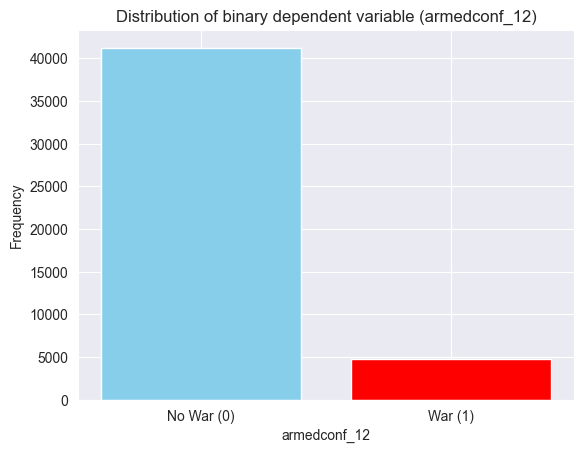

Class imbalance ratio: 8.773809523809524


In [1664]:
# Bar plot for the distribution of the binary dependent variable
counts = [train_data["armedconf_12"].value_counts()[0], train_data["armedconf_12"].value_counts()[1]]
class_imbalance_ratio = counts[0] / counts[1]
labels = ['No War (0)', 'War (1)']
colors = ['skyblue', 'red']  # Blue for 0, Red for 1

plt.bar(labels, counts, color=colors)
plt.title("Distribution of binary dependent variable (armedconf_12)")
plt.xlabel("armedconf_12")
plt.ylabel("Frequency")
plt.show()
print(f"Class imbalance ratio: {class_imbalance_ratio}")


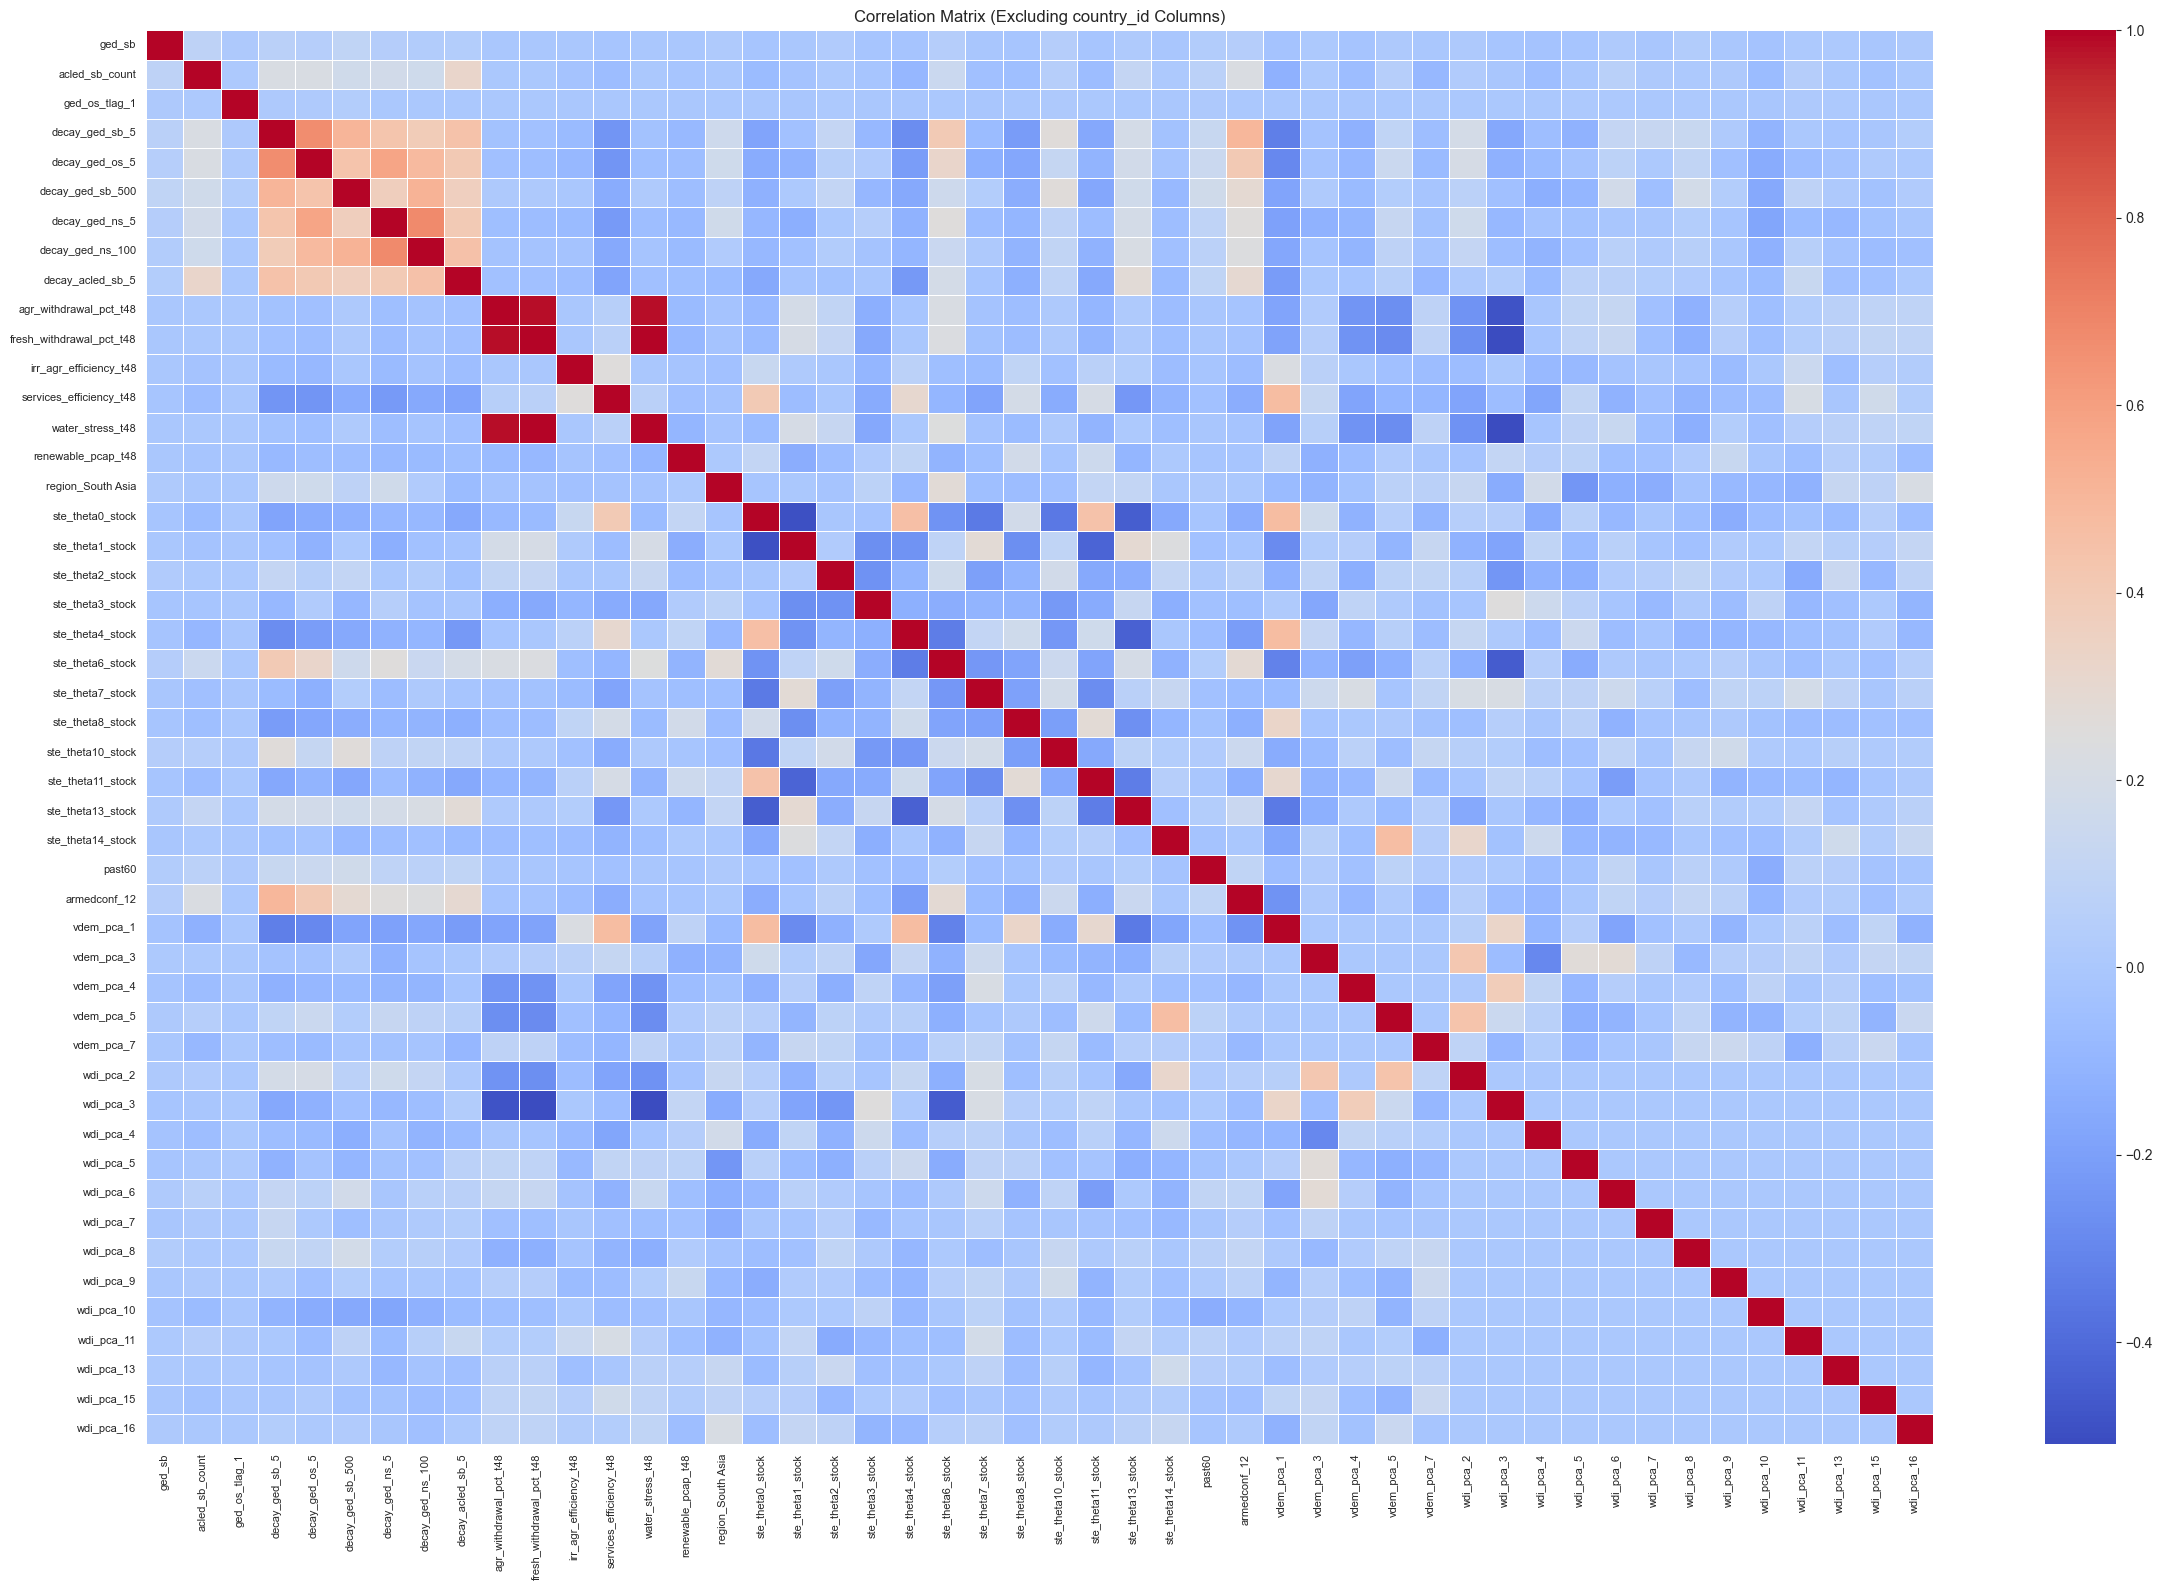

In [1665]:
# Correlation matrix for the training data
# omit one hot encoded country_id columns from the correlation matrix to avoid cluttering the heatmap
train_data_no_country_ids = train_data.loc[
    :, ~train_data.columns.str.contains("country_id", regex=True)
]

correlation_matrix = train_data_no_country_ids.corr()

plt.figure(figsize=(24, 16))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Excluding country_id Columns)")
plt.tight_layout()
plt.show()

## Model Training (main part)

In [1666]:
ADD_SAMPLE_WEIGHT_COLUMN: bool = True
if ADD_SAMPLE_WEIGHT_COLUMN:
    train_data["sample_weight"] = train_data["armedconf_12"].apply(
        lambda x: class_imbalance_ratio if x == 1 else 1
    )

    val_data["sample_weight"] = val_data["armedconf_12"].apply(
        lambda x: class_imbalance_ratio if x == 1 else 1
    )

In [1667]:
hyperparameters = {
    'CAT': {
        'iterations': 1000,
        'learning_rate': 0.1, # 0.1 - the best option
        'depth': 5, # 5 - the best option
        'l2_leaf_reg': 5, # 5 - seems to be the best option
        'border_count': 128,
    }
}

predictor: TabularPredictor = TabularPredictor(
    label="armedconf_12",
    problem_type="binary",
    sample_weight="sample_weight", # name of the column that contains the sample weights (optional) | Alternatively, you can use AUTO_WEIGHT or BALANCE_WEIGHT or None
    eval_metric="average_precision", # evaluation metric that algorithms tune
).fit(
    train_data=train_data,
    tuning_data=val_data,
    hyperparameters=hyperparameters,
    use_bag_holdout=True,
    save_bag_folds=True,
    time_limit=90, # more than enough for that CatBoost model
    presets='good',
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250112_140028"
Preset alias specified: 'good' maps to 'good_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       3.44 GB / 15.73 GB (21.9%)
Disk Space Avail:   23.73 GB / 322.15 GB (7.4%)
Presets specified: ['good']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ... Time limit = 90s
AutoGluon will save mo

In [1668]:
# performs final predictions for the test set using refitted models
predictions = predictor.predict_proba(test_data)
y_pred_prob = predictions[1] # predicted probabilities for positive class
y_true = test_data["armedconf_12"].values # true labels

## Model Evaluation

In [1669]:
LOG_ALL_METRICS = True
eval_dict = calculate_classification_metrics(
    y_true, y_pred_prob, 0.5, LOG_ALL_METRICS
)
print("Main evaluation metric - PR AUC: ", eval_dict["prauc"])

	! PR AUC score: 0.8534480466775716
Confusion matrix:
 [[1596   39]
 [  28  135]]
	Balanced Accuracy: 0.9021838239432656
	Precision: 0.7758620689655172
	Weighed precision: 0.6581580078751442
	 F1: 0.8011869436201781
	 Recall: 0.8282208588957055
	 ROC AUC score: 0.9685671938612784
	 Accuracy: 0.9627363737486095
Main evaluation metric - PR AUC:  0.8534480466775716


Best Threshold: 0.1685442328453064


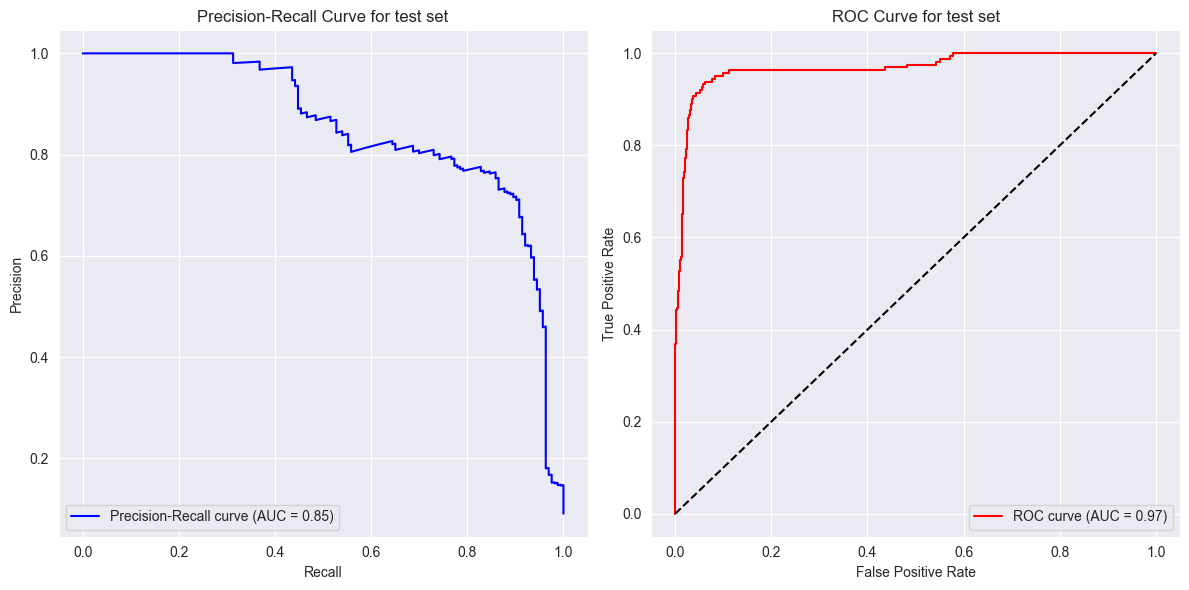

ROC AUC: 0.969
Precision-Recall AUC: 0.85


In [1670]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

f1 = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1)]
print("Best Threshold:", best_threshold)

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# Subplot for Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(
    recall,
    precision,
    color="b",
    label=f"Precision-Recall curve (AUC = {auc(recall, precision):.2f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for test set")
plt.legend(loc="lower left")

# Subplot for ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color="r", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot(
    [0, 1], [0, 1], color="black", linestyle="--"
)  # Diagonal line (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for test set")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print(f"ROC AUC: {roc_auc:.3f}")
print(f"Precision-Recall AUC: {auc(recall, precision):.2f}")

In [1671]:
feature_importance = predictor.feature_importance(test_data)
feature_importance.sort_values(ascending=False, by="importance", inplace=True)

features_to_remove = feature_importance[feature_importance["importance"] <= 0].index.tolist()

# detected a features with negative importance, add their names to .txt file and removed after
# managed to add approximately +8 percent on test set PR AUC :)

#with open("features_to_remove.txt", "w") as f: - commented a code that writes a features names to file
    #f.write("\n".join(features_to_remove))

for dataset_name, dataset in zip(["Train", "Validation", "Test"], [train_data, val_data, test_data]):
    predictions = predictor.predict_proba(dataset)
    y_pred_prob = predictions[1]
    y_true = dataset["armedconf_12"].values

    print(f"\nEvaluating on {dataset_name} dataset:")
    eval_metrics = calculate_classification_metrics(y_true, y_pred_prob, threshold=0.5, log=True)
    print(f"Main evaluation metric - PR AUC ({dataset_name}):", eval_metrics["prauc"])


Computing feature importance via permutation shuffling for 88 features using 1798 rows with 5 shuffle sets...
	9.81s	= Expected runtime (1.96s per shuffle set)
	1.18s	= Actual runtime (Completed 5 of 5 shuffle sets)



Evaluating on Train dataset:
	! PR AUC score: 0.997762073767787
Confusion matrix:
 [[40778   494]
 [    0  4704]]
	Balanced Accuracy: 0.9940153130451638
	Precision: 0.9049634474798
	Weighed precision: 0.9049634474798
	 F1: 0.9501110886689558
	 Recall: 1.0
	 ROC AUC score: 0.9997924988346764
	 Accuracy: 0.9892552636157995
Main evaluation metric - PR AUC (Train): 0.997762073767787

Evaluating on Validation dataset:
	! PR AUC score: 0.9940753185273479
Confusion matrix:
 [[6651  123]
 [   0  607]]
	Balanced Accuracy: 0.9909211691762622
	Precision: 0.8315068493150685
	Weighed precision: 0.8315068493150685
	 F1: 0.9080029917726253
	 Recall: 1.0
	 ROC AUC score: 0.999594340021859
	 Accuracy: 0.9833355913832814
Main evaluation metric - PR AUC (Validation): 0.9940753185273479

Evaluating on Test dataset:
	! PR AUC score: 0.8534480466775716
Confusion matrix:
 [[1596   39]
 [  28  135]]
	Balanced Accuracy: 0.9021838239432656
	Precision: 0.7758620689655172
	Weighed precision: 0.6581580078751442
	

## Submission

Best validation average precision score (before refit): 0.9940753185273479


Best test average precision score: 0.8534480466775716

## Ideas section

Having more time, what would you try?
* Maybe including more data. Which data?
* Optimising the model further. How?
* Maybe something completely different?


Submission about work and my thoughts about further improvements:

I tried XGB and CatBoost models with manually tuned hyperparameters, and CatBoost seems to give better results with better speed (the model learned three times fastert than XGB). I tried to use automatic hyperparameter selection via autogluon.core.space, but abandoned this idea due to lack of time and focused on other things.

I attempted to remove highly correlated features from the dataset (to reduce multicollinearity). While this improved accuracy when using XGBoost, it had the opposite effect on CatBoost, as CatBoost tends to handle such features more effectively. Moreover, CatBoost demonstrated significantly better performance in terms of speed—approximately three times faster with the same hyperparameters. Therefore, I decided to move forward with CatBoost as my primary model.
Additionally, I optimized the feature set by removing the least important features, which helped improve model efficiency vastly (attached a photo with comparison). Finally, I fine-tuned the `sample_weight` parameter by multiplying the class imbalance by `class_imbalance_ratio` (not sure about this, I think will be better to adjust the sample weight parameters during model training part (balanced or auto), but when I tried it, I didn't see much change).

I tried to get the `best_threshold`, but I didn't see any dependence of the metric results on this.

If I have more time:

* **Maybe including more data. Which data?**
  - I would try collecting additional data that could improve the representation of the minority class, as the class imbalance is a key challenge for this task. For example, more labeled data from underrepresented categories would likely improve the model's recall and precision for the minority class. Additionally, I could explore external datasets with similar characteristics or try synthetic data generation methods (SMOTE).

* **Optimising the model further. How?**
  - Perform hyperparameter tuning more extensively using techniques like grid search or Bayesian optimization to improve the CatBoost model further (maybe Optuna?).
  - Experiment with custom and ensemble loss functions like Focal Loss to penalize errors on hard-to-classify samples.

* **Maybe something completely different?**
  - Experiment with feature engineering techniques to extract new, meaningful features or reduce noise. This could involve domain-specific transformations or dimensionality reduction methods (PCA).
  - I would try to optimize and use XGB model instead of CatBoost, since it can give more perfomance, but because of lack of time I decided to move forward with CatBoost as my primary model.
  - Also I would like to use SHAP (SHapley Additive exPlanations) to better understand the model's predictions and gain insights into feature importance.

Overall, in my opinion, the main things that can still help improve accuracy are related with class imbalance and model (or model hyperparameteres) selection or predictor perfomance presets (currently I have chosen the "good" preset, but if you have a lot of time to train the model, maybe another preset will give more accuracy).